In [1]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm


In [2]:
### SET HYPERPARAMETERS ###
city = "nyc"
t_window = 210  # Training window in days
k_days = 7  # Epoch length in days
threshold = 100  # Performance degradation threshold (adjust as needed)
max_simulation_days = 104  # Maximum number of simulation days
topK = 20
version = "full"
ps = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
### ------------------- ###


In [3]:
#open the properties folder. The property names are the same of the files
properties = os.listdir(f'properties_{city}')
properties = [x.split('.')[0] for x in properties]
properties.remove("rog")
properties

['gamma',
 'gini_trajectories',
 'nodes_coloc',
 'unc_entropy',
 'rich_club_density',
 'gini_visits']

In [4]:
property = properties[0]
# Load the property data
df_prop = pd.read_csv(f'properties_{city}/{property}.csv', sep=",", names=['seed', 'alg', 'p', 'value'], header=None)
df_prop


,seed,alg,p,value
0,500,UserKNN,0.0,2.096872
1,500,UserKNN,0.2,1.901790
2,500,UserKNN,0.4,1.751917
3,500,UserKNN,0.6,1.628028
4,500,UserKNN,0.8,1.496063
...,...,...,...,...
241,504,PGN,0.2,1.580479
242,504,PGN,0.4,1.124600
243,504,PGN,0.6,0.895710
244,504,PGN,0.8,0.676205


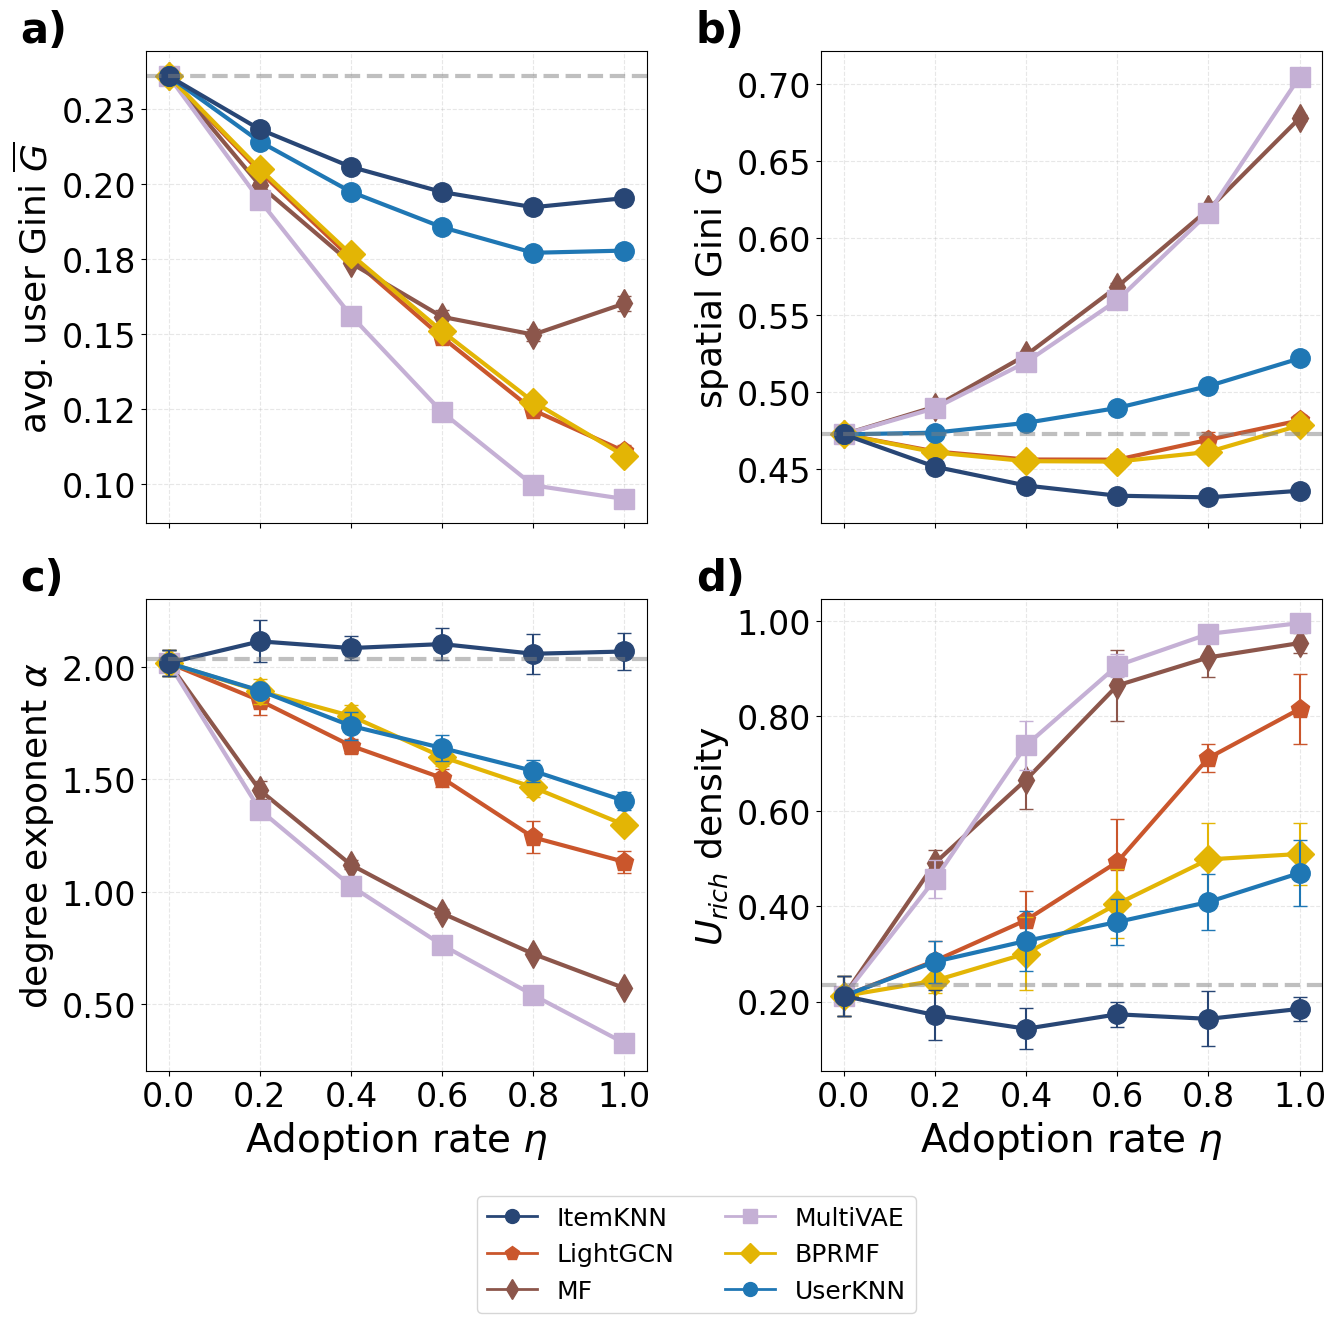

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import numpy as np

city = "nyc"
property_files = os.listdir(f'properties_{city}')

# Create a 2x3 grid of subplots with shared x-axis
fig = plt.figure(figsize=(14, 14), dpi=100)

# Create 2x2 grid of truly square subplots
ax1 = fig.add_subplot(221, aspect='equal')
ax2 = fig.add_subplot(222, aspect='equal')

# Create bottom row with sharex properly set
ax3 = fig.add_subplot(223, aspect='equal', sharex=ax1)
ax4 = fig.add_subplot(224, aspect='equal', sharex=ax2)

# Put into a 2x2 array to match your existing code structure
axes = np.array([[ax1, ax2], [ax3, ax4]])

# Ensure x-ticks only show on the bottom row
ax1.tick_params(axis='x', labelbottom=False)
ax2.tick_params(axis='x', labelbottom=False)



# Create a color palette for all algorithms
all_algorithms = set()
for property_file in property_files:
    if property_file.endswith('.csv'):
        df = pd.read_csv(f'properties_{city}/{property_file}', sep=",", names=['seed', 'alg', 'p', 'value'], header=None, skipinitialspace=True)
        all_algorithms.update(df['alg'].unique())

algorithms = sorted(list(all_algorithms))
#remove MF from algorithms

algorithms.remove("CPop")
algorithms.remove("CatRec")
algorithms.remove("PGN")

# Fixed colors for specific algorithms
color_dict = {
    "UserKNN": "#1f77b4",  # Blue
    "ItemKNN": "#284675",  # Darker blue
}

# Remaining algorithms, use nature palette
remaining_algs = [alg for alg in algorithms if alg not in color_dict]
nature_palette = [
    "#ca562c",  # Rusty orange
    "#8c564b",  # Muted red-brown
    "#c5b0d5",  # Soft lavender-gray
    "#e3b505",  # Delicate orange / warm mustard
]

for i, alg in enumerate(remaining_algs):
    color_dict[alg] = nature_palette[i % len(nature_palette)]

# Define specific positions for each property
property_positions = {
    "gamma": (1, 0),
    "rich_club_density": (1, 1),
    "gini_trajectories": (0, 0),
    "gini_visits": (0, 1),
}

property2name = {
    "gamma": r"degree exponent $\alpha$",
    "rich_club_density": r"$U_{rich}$ density",
    "rog": "RoG",
    "gini_trajectories": r"avg. user Gini $\overline{G}$",
    "gini_visits": r"spatial Gini $G$",
}

# Define line styles and markers for each algorithm
line_styles = {alg: '-' for alg in algorithms}
markers = {alg: 'o' for alg in algorithms if alg in ["UserKNN", "ItemKNN"]}
markers.update({
    "MultiVAE": "s",
    "LightGCN": "p",
    "MF": "d",
    "Neural_BPRMF": "D",
})



# Process each property file
for property_file in property_files:
    if not property_file.endswith('.csv'):
        continue

    property_name = property_file.split('.')[0]

    # Skip if not in our predefined positions
    if property_name not in property_positions:
        continue

    row, col = property_positions[property_name]

    df = pd.read_csv(f'properties_{city}/{property_file}', sep=",", names=['seed', 'alg', 'p', 'value'], header=None, skipinitialspace=True)

    # Calculate mean and std dev
    grouped = df.groupby(['alg', 'p'])['value'].agg(['mean', 'std']).reset_index()

    ax = axes[row, col]
    #set ax to be square

    # Define plotting order
    plotting_order = [alg for alg in algorithms if alg not in ["CatRec", "CPop", "UserKNN", "ItemKNN"]] + [ "UserKNN", "ItemKNN"]

    # Plot algorithms in the defined order
    for alg in plotting_order:
        if alg in grouped['alg'].values:
            alg_data = grouped[grouped['alg'] == alg].sort_values(by='p')
            ax.plot(alg_data['p'], alg_data['mean'],
                   marker=markers[alg],
                   linestyle=line_styles[alg],
                   linewidth=3,
                   markersize=14,
                   label=alg,
                   color=color_dict[alg])

            # Add error bars representing standard deviation as vertical bars
            ax.errorbar(alg_data['p'], alg_data['mean'], yerr=alg_data['std'],
                        fmt='none',  # No marker or line for error bars
                        capsize=5,   # Size of the error bar caps
                        ecolor=color_dict[alg],
                        elinewidth=1.5)

    # Labels and styling
    ax.set_ylabel(property2name[property_name], fontsize=26)
    #maximum 2 decimal places
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    # set xticklables to be exactly [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] (one decimal)
    ax.set_xticks(ps)
    ax.set_xticklabels([f"{p:.1f}" for p in ps], fontsize=24)
    #increase xticklabel size
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.grid(alpha=0.3, linestyle='--')
    #ensure the aspect ratio. ax is square
    ax.set_aspect('auto')

    # Add x-label to bottom row
    if row == 1:
        ax.set_xlabel(r'Adoption rate $\eta$', fontsize=28)

    # Set formatter to use a maximum of 2 decimal places for both axes
    if col != 0 and row != 0:
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    # horizontal grey line constant to the value of alg_data at p=0
    if len(grouped[grouped['p'] == 0]['mean'].values) > 0:
        p0_value = grouped[grouped['p'] == 0]['mean'].values[0]
        ax.axhline(y=p0_value, color='gray', linestyle='--', alpha=0.5, linewidth=3)

algorithms2names = {
    "MF": "MF",
    "MultiVAE": "MultiVAE",
    "Neural_BPRMF": "BPRMF",
    "UserKNN": "UserKNN",
    "LightGCN": "LightGCN",
    "CPop": "CPop",
    "CatRec": "IPop",
    "ItemKNN": "ItemKNN",
    "PGN": "PGN",
}

# Create handles for legend
handles = []
labels = []
for alg in algorithms:
    handles.append(plt.Line2D([0], [0],
                              color=color_dict[alg],
                              marker=markers[alg],
                              linestyle=line_styles[alg],
                              linewidth=2,
                              markersize=10))
    labels.append(algorithms2names[alg])

# Add a centered legend below all subplots
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, 0.03),
           ncol=2, fontsize=18, title="")

#titling of subplots (a,b,c,d)
ax1.set_title(r"a)", fontsize=30, loc='left',fontweight='bold', x=-0.25)
ax2.set_title(r"b)", fontsize=30, loc='left',fontweight='bold', x=-0.25)
ax3.set_title(r"c)", fontsize=30, loc='left', fontweight='bold', x=-0.25)
ax4.set_title(r"d)", fontsize=30, loc='left', fontweight='bold', x=-0.25)


# Adjust the layout with extra space at bottom for legend
plt.tight_layout(pad = 3)
plt.subplots_adjust(bottom=0.212)  # Make room for the legend at the bottom
plt.savefig(f"figures/MultiALG_comparison.pdf", bbox_inches='tight', dpi=300)

plt.show()